# Comparison of output from coupled PRMS6 BMIs (Surface, Soil, Groundwater, and Streamflow)

Below is the coupled bmi fortran code
``` fortran 
program irf_test

  use bmif_2_0, only: BMI_MAX_UNITS_NAME, BMI_SUCCESS, BMI_FAILURE
  use bmiprmssurface
  use bmiprmssoil
  use bmiprmsgroundwater
  use bmiprmsstreamflow
  implicit none

  type (bmi_prms_surface) :: m_surf
  type (bmi_prms_soil) :: m_soil
  type (bmi_prms_groundwater) :: m_gw
  type (bmi_prms_streamflow) :: m_strm
  integer :: s, i
  double precision :: time, time0, time1
  character (len=BMI_MAX_UNITS_NAME) :: time_units
  character (len=*), parameter :: control_file = './pipestem/control.simple1'
  character (len=*), parameter :: control_file1 = './pipestem_surface/control_surface.simple1'
  character (len=*), parameter :: control_file2 = './pipestem_soil/control_soil.simple1'
  character (len=*), parameter :: control_file3 = './pipestem_groundwater/control_groundwater.simple1'
  character (len=*), parameter :: control_file4 = './pipestem_streamflow/control_streamflow.simple1'
  double precision :: endtime

  write (*,"(a)",advance="no") "Initializing..."
  s = m_surf%initialize(control_file1)
  s = m_soil%initialize(control_file2)
  s = m_gw%initialize(control_file3)
  s = m_strm%initialize(control_file4)
  !s = surface2soil(m_surf, m_soil)
  s = m_surf%get_end_time(endtime)
  do i = 1,int(endtime)
      s = m_surf%update()
      s = surface2soil(m_surf, m_soil)
      s = m_soil%update()
      s = soil2surface(m_soil, m_surf)
      s = surf_soil2gw(m_surf, m_soil, m_gw)
      s = m_gw%update()
      s = surf_soil_gw2strm(m_surf, m_soil, m_gw, m_strm)
      s = m_strm%update()
  enddo
  write (*,*) "Done."


  write (*,"(a)", advance="no") "Finalizing..."
  s = m_surf%finalize()
  s = m_soil%finalize()
  s = m_gw%finalize()
  s = m_strm%finalize()
  write (*,*) "Done"
  ```

In [1]:
# code for specific functions in this notebook. See repo Readme.md for install instructions
import prms6bmi

In [2]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# Set paths to output files

streamflow_file = Path('B:/gitbmi/bmi-prms6-streamflow/bmi_prms_streamflow/irf_ex/output/summary_streamflow_daily.nc')
prms_file = Path('B:/gitbmi/prms/_build/prms/pipestem/output/summary_daily.nc')
clim_file = Path('B:/gitbmi/prms/_build/prms/pipestem/daymet.nc')
dstrm = xr.open_dataset(streamflow_file)
dprms = xr.open_dataset(prms_file)
clim = xr.open_dataset(clim_file)

---
Find the min/max dates of the climate data

---

In [5]:
clim_date_min = clim.time.min().values
clim_date_max = clim.time.max().values
print(clim_date_min, clim_date_max)
clim

1980-01-01T00:00:00.000000000 2016-12-31T00:00:00.000000000


<xarray.Dataset>
Dimensions:  (hru: 14, time: 13515)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2016-12-31
  * hru      (hru) int32 57874 57875 57878 57881 ... 57869 57870 57864 57865
Data variables:
    prcp     (time, hru) float32 ...
    tmax     (time, hru) float32 ...
    tmin     (time, hru) float32 ...
Attributes:
    Description:                Climate by HRU
    Bandit_version:             0.6.3
    NHM_version:                ff1b7fc29610bac9f5daa1ca0563d9f6962ddcf0
    history:                    Mon Apr  8 10:11:53 2019: ncks -A tmin.nc day...
    history_of_appended_files:  Mon Apr  8 10:11:53 2019: Appended file tmin....
    NCO:                        netCDF Operators version 4.7.8 (Homepage = ht...

---

#### Take a look at the ouput from the bmi-prms6-streamflow bmi

---

In [6]:
dstrm

<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 731)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 1981-12-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 ...
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_moist_tot       (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    ssres_flow           (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru

---

#### get start/end dates for simulation and plot Precipitation, Temperature max/min

---

In [7]:
sim_start_date = dstrm.time.min()
sim_end_date = dstrm.time.max()

In [8]:
# the following results from a future-warning message so implemented below
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

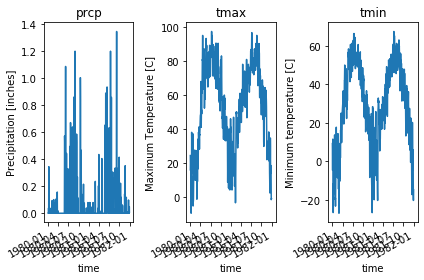

In [9]:
fig, ax = plt.subplots(ncols=3)
t_hru = 13
prms6bmi.plot_climate(clim, t_hru, 'prcp', sim_start_date, sim_end_date, ax[0])
prms6bmi.plot_climate(clim, t_hru, 'tmax', sim_start_date, sim_end_date, ax[1])
prms6bmi.plot_climate(clim, t_hru, 'tmin', sim_start_date, sim_end_date, ax[2])
plt.tight_layout()
plt.show()

---

#### Compare output of the BMI-coupled model with the output from PRMS6

* Output is the segment outflow for each of the 7-segements in the pipestem example

---

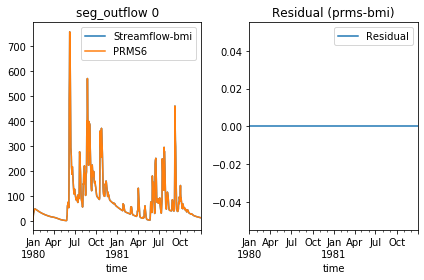

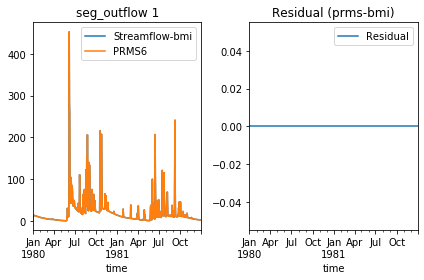

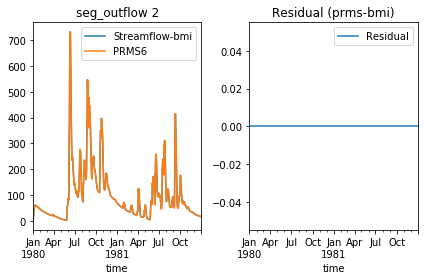

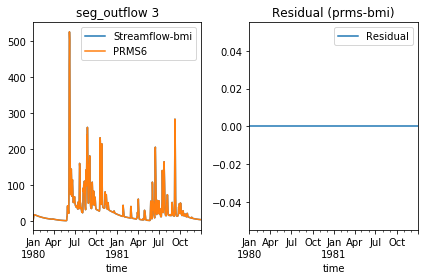

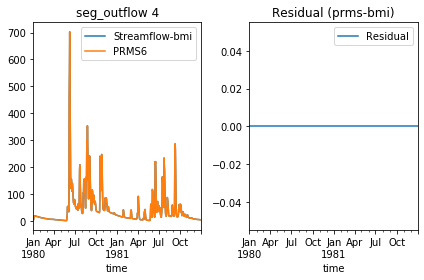

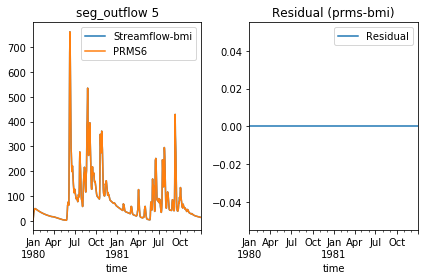

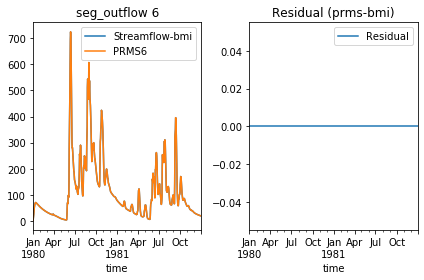

In [10]:
# for seg in dprms.nsegment:
nsegment = dprms['seg_outflow'].sizes['nsegment']
for seg in range(nsegment):
    fig, ax = plt.subplots(ncols=2)
    prms6bmi.bmi_prms6_value_plot(dstrm, seg, 'seg_outflow', 'Streamflow-bmi', sim_start_date, sim_end_date, ax[0])
    prms6bmi.bmi_prms6_value_plot(dprms, seg, 'seg_outflow', 'PRMS6', sim_start_date, sim_end_date, ax[0])
    prms6bmi.bmi_prms6_residual_plot(dstrm, dprms, seg, 'seg_outflow', 'Residual', sim_start_date, sim_end_date, ax[1])
#     plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
#save the last figure
fig.savefig('outflow.png')